# 4.- Running the MCMC

Nauyaca uses a Parallel-Tempering sampling algorithm ($\texttt{ptemcee}$; Vousden et al., 2015) to explore the parameter space at different walker temperatures. While walkers at 'hotter' temperatures can explore the parameter space more freely, the walkers at lower temperatures explore in detail small regions with high probability. There is an exchange between walkers at different temperatures, allowing the walkers do not get stuck in local high probability regions. The posteriors are drawn from the walkers at temperature 0 (the coldest).

Let's import Nauyaca and other useful libraries for analysis

In [1]:
import nauyaca as nau

import matplotlib.pyplot as plt
import numpy as np

As before, let's load the Planetary System object

In [2]:
PS = nau.PlanetarySystem.load_json('SystemX.json')
print(PS)

--> Parameter -ecc- of planet -Planet-b- set to lower physical limit: 1e-06
--> Parameter -ecc- of planet -Planet-c- set to lower physical limit: 1e-06

 =========== Planetary System Summary =========== 
--> Parameter -ecc- of planet -Planet-b- set to lower physical limit: 1e-06
--> Parameter -ecc- of planet -Planet-c- set to lower physical limit: 1e-06

System: SystemX
Mstar: 0.9132 Msun |  Rstar: 0.8632 Rsun
Number of planets: 2
Planet information:
------
Planet1: Planet-b
  Boundaries:
    mass: (1, 20.0)  [M_earth]
    period: (5.35, 5.36)  [d]
    ecc: (1e-06, 0.2)   
    inclination: (85, 95)  [deg]
    argument: (0.0, 360)  [deg]
    mean_anomaly: (0.0, 360)  [deg]
    ascending_node: (88.36, 88.36)  [deg]
  TTVs: True
------
Planet2: Planet-c
  Boundaries:
    mass: (1, 50)  [M_earth]
    period: (11.83, 11.84)  [d]
    ecc: (1e-06, 0.2)   
    inclination: (85, 95)  [deg]
    argument: (0.0, 360)  [deg]
    mean_anomaly: (0.0, 360)  [deg]
    ascending_node: (0.0, 180.0)  [deg

## 4.1 Initializing walkers

Before running the MCMC, we need to decide which the initial prior will be. The prior is all that information that you can provide as initial guess for the exploration. We refer to $walker$ as those data that represent a point in the parameter space. Initial walkers constitute a group of data points in the space of $\mathrm{N_{dim}}$ dimensions that are initially supplied to the MCMC.

For our current problem, the number of dimensions to explore is:

In [3]:
PS.ndim

13

Thus, each walker will be an array of $\mathrm{N_{dim}}$ dimensions.

Let's define the main parameters to run the MCMC. We will run the MCMC along 3000 iterations saving each 50 steps.

In [4]:
Ntemps = 8        # Number of temperatures
Nwalkers = 100    # Number of walkers per temperature
Tmax = 50        # Maximum temperature. If None, then Parallel-Tempering chose an appropiate maximum temperature

Itmax = 3000      # Maximum number of steps
Intra_steps = 50 # Number of steps to save the chains

Nauyaca provides 4 forms of easily initialize walkers through the 'initial_walkers' function in the 'utils' module. Additionally, you can provide your own walkers' initial position as long as they are inside the valid boundaries. 

**IMPORTANT:** Initial walkers should be provided in an array of shape (Ntemps, Nwalkers, Ndim)

Let's generate these 4 ways of initial walkers and plot them using the 'Plots' module

In [6]:
nauplot = nau.Plots(PS)

###  4.1.1 Uniform distribution

For all the planetary parameters, initialize walkers from an uniform distribution
along the established boundaries for each planet. Using this option is unnecesary to run optimizers previously. We call it from the 'utils' module

In [7]:
walkers_uniform = nau.utils.init_walkers(PS, 
                                distribution="Uniform", 
                                ntemps=Ntemps, 
                                nwalkers=Nwalkers)


--> Selected distribution: Uniform


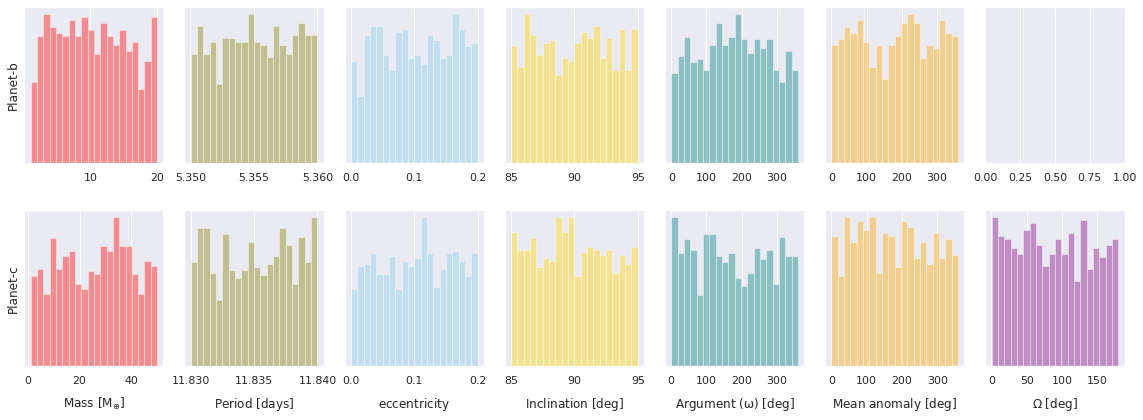

In [8]:
# Show the initial uniform population 
nauplot.plot_hist(chains=walkers_uniform)

**Note:** If there are constant values in the planet's boundaries, then that parameter will be skipped and values will not appear in the initial walkers. Here, panels without information corresponds to planet parameters that remain as fixed. In this case, the constant parameter(s) and its value correspond to:

In [9]:
for constant in PS.constant_params.keys():
    param = PS.params_names_all.split()[constant]
    value = PS.constant_params[constant]
    print(f"{param}: {value}")

ascending_node1: 88.36


### 4.1.2 Gaussian distribution

In order to use this function, you need to provide the information comming from the optimizers saved in the **_cube.opt** file. Let's load the results from the optimizers that we got in the previous tutorial:

In [10]:
RESULTS_opt = np.genfromtxt(f'{PS.system_name}_cube.opt')

Provide the results directly from the optimizers (through opt_data argument) and construct a gaussian with the mean and standard deviation of the solutions along each dimension. In opt_data, pass RESULTS_opt (from optimizers or from file). Argument 'fbest' selects a fraction of the best solutions and discard the rest. For example, fbest=.3 takes the best 30% of the solutions, according to their $\chi^2$

In [11]:
walkers_gaussian = nau.utils.init_walkers(PS, 
                                   distribution = "Gaussian",
                                   opt_data = RESULTS_opt, 
                                   fbest = 0.3,
                                   ntemps = Ntemps, 
                                   nwalkers = Nwalkers) 


--> Selected distribution: Gaussian
    24 of 80 solutions taken


**Note:** the walkers_gaussian variable contains the walkers information normalized between 0 and 1. Try printing that variable to corroborate. That's a map between the physical boundaries and the hypercube with which Nauyaca internally works. However, we can visualize the physical results when passing that variable to the Plots module:

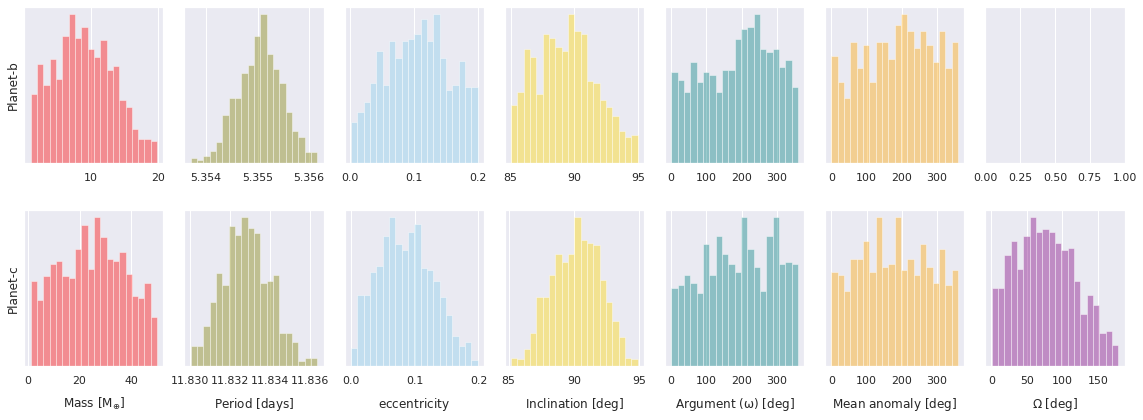

In [12]:
nauplot.plot_hist(chains=walkers_gaussian)

That will be the initial distribution of walkers

### 4.1.3 Picked distribution

Provide the results of the optimizers (through opt_data argument) to construct a discrete distribution by randomly selecting values around the optimizer solutions. In opt_data, pass RESULTS_opt (from optimizers) or results_opt (from file) fbest selects a fraction of the best solutions and discard the rest. For example, .3 takes the 30% of the solutions with the best $\chi^2$

In [20]:
walkers_picked = nau.utils.init_walkers(PS, 
                                 distribution = "Picked", 
                                 opt_data = RESULTS_opt, 
                                 fbest = .3,
                                 ntemps = Ntemps, 
                                 nwalkers = Nwalkers)


--> Selected distribution: Picked
    24 of 80 solutions taken


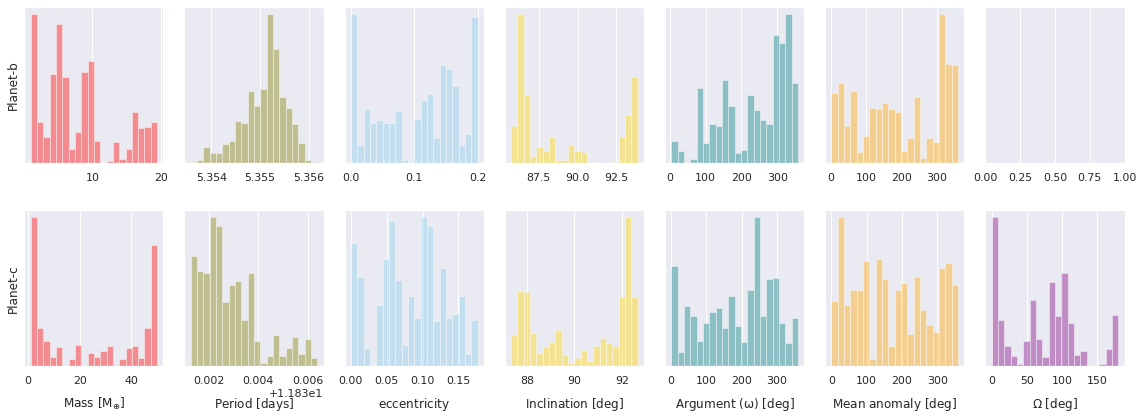

In [21]:
nauplot.plot_hist(chains=walkers_picked)

### 4.1.4 Ladder distribution

Provide the results of the optimizers (through opt_data argument).
This method separate the solutions from optimizers in chunks corresponding to the number of temperatures. Then, each temperature draw their own walkers by following the rule:
First temperature draw walkers from the first chunk (which includes the solution with the topmost solution). Second temperature draw walkers from first and second chunks. Third temperature draw walkers from first, second and third chunks. The same rule follows for the rest of the temperatures.

In opt_data, pass RESULTS_opt (from optimizers) or results_opt (from file). fbest selects a fraction of the best solutions and discard the rest. For example, .3 takes the 30% of the solutions with the best $\chi^2$

In [22]:
walkers_ladder = nau.utils.init_walkers(PS, 
                                distribution = "Ladder",
                                opt_data = RESULTS_opt, 
                                fbest = 0.3,
                                ntemps = Ntemps, 
                                nwalkers = Nwalkers)  



--> Selected distribution: Ladder
    24 of 80 solutions taken


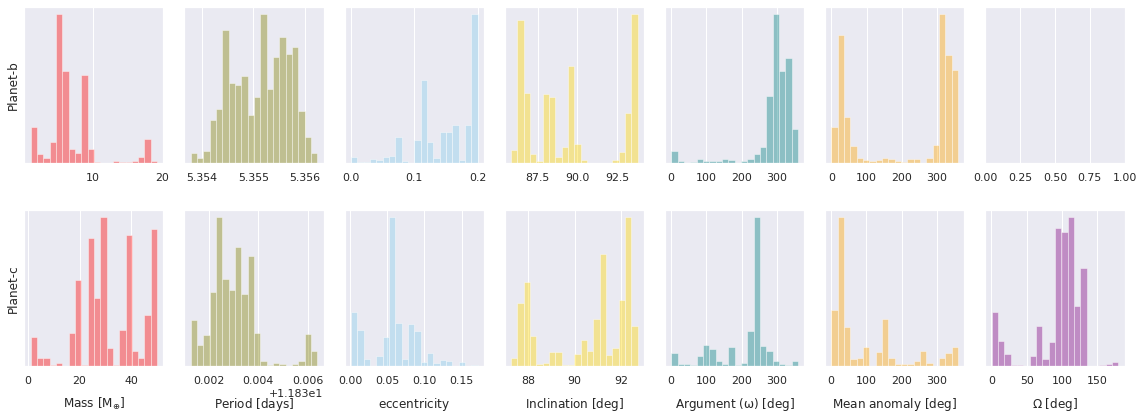

In [23]:
nauplot.plot_hist(chains=walkers_ladder)

## 4.2 Running the MCMC

Let's run the MCMC using the initial walkers from the Ladder distribution generated above. Also provide the necessary keyword arguments. Many of them were defined at the beggining of section 3.1

In [24]:
nauMCMC = nau.MCMC(
            PS,                             # Planetary System object
            p0 = walkers_ladder,            # Initial population of walkers 
            tmax = Tmax,                    # Maximum temperature
            itmax = Itmax,                  # Maximum nomber of iterations (steps)
            intra_steps = Intra_steps,      # Save data each this number of steps
            cores = 8,                      # Number of cores to run in parallel
            suffix='')

In [25]:
RESULTS_mcmc = nauMCMC.run()


 =========== PARALLEL-TEMPERING MCMC ===========

--> Starting date:  2021-02-09 01:03
--> Reference epoch of the solutions:  0.0  [JD]
--> Results will be saved at:  ./SystemX.hdf5
--> MCMC parameters:
      -ntemps: 8
      -nwalkers: 100
      -itmax: 3000
      -intra_steps: 50

--------- Iteration:  50
 Mean tau: 0.308
 Accepted swap fraction in Temp 0:  0.05
 Mean acceptance fraction Temp 0:  0.13
 Mean likelihood:  -15513.886954
 Maximum likelihood:  (0, 32) 206.744198
 Current mean likelihood dispersion:  0.0
 Saving time: 0.04835 sec
 Elapsed time:  0.2879 min
--------- Iteration:  100
 Mean tau: 0.591
 Accepted swap fraction in Temp 0:  0.028
 Mean acceptance fraction Temp 0:  0.132
 Mean likelihood:  -14.443238
 Maximum likelihood:  (0, 23) 293.685857
 Current mean likelihood dispersion:  7749.721858
 Saving time: 0.01226 sec
 Elapsed time:  0.5757 min
--------- Iteration:  150
 Mean tau: 0.85
 Accepted swap fraction in Temp 0:  0.02
 Mean acceptance fraction Temp 0:  0.118

--------- Iteration:  1400
 Mean tau: 1.885
 Accepted swap fraction in Temp 0:  0.017
 Mean acceptance fraction Temp 0:  0.063
 Mean likelihood:  344.007802
 Maximum likelihood:  (0, 26) 359.979752
 Current mean likelihood dispersion:  4.298019
 Saving time: 0.02794 sec
 Elapsed time:  11.0572 min
--------- Iteration:  1450
 Mean tau: 1.888
 Accepted swap fraction in Temp 0:  0.018
 Mean acceptance fraction Temp 0:  0.062
 Mean likelihood:  343.946536
 Maximum likelihood:  (0, 26) 366.40745
 Current mean likelihood dispersion:  3.726814
 Saving time: 0.02655 sec
 Elapsed time:  11.4562 min
--------- Iteration:  1500
 Mean tau: 1.892
 Accepted swap fraction in Temp 0:  0.019
 Mean acceptance fraction Temp 0:  0.062
 Mean likelihood:  344.536626
 Maximum likelihood:  (0, 26) 371.486654
 Current mean likelihood dispersion:  3.818411
 Saving time: 0.02528 sec
 Elapsed time:  11.8529 min
--------- Iteration:  1550
 Mean tau: 1.896
 Accepted swap fraction in Temp 0:  0.02
 Mean acceptance fr

--------- Iteration:  2800
 Mean tau: 1.376
 Accepted swap fraction in Temp 0:  0.024
 Mean acceptance fraction Temp 0:  0.048
 Mean likelihood:  364.224608
 Maximum likelihood:  (0, 25) 378.032026
 Current mean likelihood dispersion:  6.356196
 Saving time: 0.02189 sec
 Elapsed time:  22.6359 min
--------- Iteration:  2850
 Mean tau: 1.153
 Accepted swap fraction in Temp 0:  0.024
 Mean acceptance fraction Temp 0:  0.048
 Mean likelihood:  364.767838
 Maximum likelihood:  (0, 24) 379.907931
 Current mean likelihood dispersion:  6.35313
 Saving time: 0.02203 sec
 Elapsed time:  23.0779 min
--------- Iteration:  2900
 Mean tau: 0.913
 Accepted swap fraction in Temp 0:  0.024
 Mean acceptance fraction Temp 0:  0.048
 Mean likelihood:  365.792625
 Maximum likelihood:  (0, 24) 380.456379
 Current mean likelihood dispersion:  6.552076
 Saving time: 0.03091 sec
 Elapsed time:  23.5953 min
--------- Iteration:  2950
 Mean tau: 0.686
 Accepted swap fraction in Temp 0:  0.024
 Mean acceptance f

After the mcmc run ends, it returns the sampler object from $\texttt{ptemcee}$, with the following attributes:

In [26]:
RESULTS_mcmc.__dict__.keys()

dict_keys(['_random', '_likeprior', 'a', 'nwalkers', 'dim', 'adaptation_time', 'adaptation_lag', '_betas', 'pool', '_chain', '_logposterior', '_loglikelihood', '_beta_history', '_time', '_p0', '_logposterior0', '_loglikelihood0', 'nswap', 'nswap_accepted', 'nprop', 'nprop_accepted'])

We will deeply inspect these attributes in the following tutorial. 

Okey, at this point there are two files that have been saved with the following extesions:

* **.hdf5:** It contains the main results from the MCMC run. It will be useful for posterior analysis. It also can be provided to the Plots module to plot default figures from Nauyaca. This file is portable and is useful to restart an MCMC in other time or in another computer. 

* **.best:** It is a file containing the best solution (normalized) of each saved iteration. It correspond to the solution with the 'Maximum likelihood' indicated in the outputs.


## 4.3 Results (fast version)


For the following analysis, let's make a burnin of the first 25% of the chains. Also remember that results are taken from temperature 0.

In [3]:
burn = 0.25  # Fractional lenght of the initial chains to be discarted

**MCMC Summary**

An easy way to summarize the current MCMC run is through the mcmc_summary method in utils, passing the name of the .hdf5 file.

In [28]:
posteriors = nau.utils.mcmc_summary(PS, hdf5_file=f'{PS.system_name}.hdf5', burnin=burn)

--> Planetary System:  SystemX
    Stellar mass:  0.9132
    Stellar radius:  0.8632
    Number of planets:  2
--> Planets:
       Planet1: Planet-b
       Planet2: Planet-c
    
--------------------------
--> MCMC parameters
    Ntemps:  8
    Nwalkers per temperature:  100
    Number of iterations:  3000
    Thining:  50
    Burnin:  0.25
    Chain shape:  (100, 46, 13)
--------------------------
      RESULTS             
--> Results in File:   SystemX.hdf5
--> Reference epoch of the solutions:  0  [JD]
--> Best solution in MCMC
    Logl:  380.45638
          mass period ecc inclination argument mean_anomaly ascending_node
Planet1: 5.3404   5.3553   0.1742   90.8035   311.4558   353.4077   88.36
Planet2: 22.735   11.8329   0.0702   89.2394   217.9614   54.1509   108.3325
--------------------------
--> MCMC medians and 1-sigma errors
             mass1      5.84 ^{+0.2}_{-0.38}
           period1      5.3554 ^{+0.0}_{-0.0001} 
              ecc1      0.182 ^{+0.005}_{-0.006}
      in

That function prints a summary of the MCMC run where we can see the best solution found along the entire run and the medians of the posteriors with 1-$\sigma$ erros, corresponding to percentiles 16 and 84. Furthermore, it returns a dictionary with the flatten chains of each planetary parameter:

In [29]:
posteriors

{'mass1': array([5.90170211, 5.90476092, 5.82696804, ..., 5.47092934, 5.47092934,
        5.47329454]),
 'period1': array([5.35540545, 5.35539735, 5.35539626, ..., 5.35528304, 5.35528304,
        5.35528216]),
 'ecc1': array([0.19074787, 0.19014844, 0.18897232, ..., 0.17291657, 0.17291657,
        0.17292826]),
 'inclination1': array([89.95321787, 89.85101014, 89.71784691, ..., 90.06152942,
        90.06152942, 90.06119356]),
 'argument1': array([314.4463756 , 314.15694189, 314.09362994, ..., 310.8637328 ,
        310.8637328 , 310.83875908]),
 'mean_anomaly1': array([348.07148859, 348.49536411, 348.67950097, ..., 354.28213803,
        354.28213803, 354.31268199]),
 'mass2': array([25.17243442, 25.04691061, 24.21344025, ..., 22.34918618,
        22.34918618, 22.33961057]),
 'period2': array([11.83303475, 11.83303886, 11.83303221, ..., 11.83298399,
        11.83298399, 11.83298538]),
 'ecc2': array([0.05832215, 0.05859293, 0.06129925, ..., 0.06947093, 0.06947093,
        0.06946881]),
 

Now, it's easier to analyze individual parameters. 

Let's plot for example, the posterior of the 'mass1' and calculate the mean:

Mean: 5.774119731641769


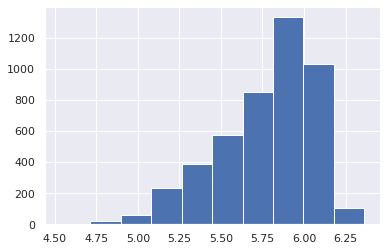

In [30]:
plt.hist(posteriors['mass1']);

mean = np.mean(posteriors['mass1'])
print(f"Mean: {mean}")

All the results saved in the .hdf5 file can be accessed through the method 'get_mcmc_results'. First, let's print which keys are available by passin the hdf5 file and the which_keys set to True

In [31]:
nau.utils.get_mcmc_results(f'{PS.system_name}.hdf5', which_keys=True)

Available keywords: 
 ['ACC_FRAC0', 'AUTOCORR', 'BESTLOGL', 'BESTSOLS', 'BETAS', 'BOUNDS', 'BOUNDSP', 'CHAINS', 'COL_NAMES', 'CORES', 'INDEX', 'INTRA_STEPS', 'ITER_LAST', 'ITMAX', 'MEANLOGL', 'MSTAR', 'NAME', 'NDIM', 'NPLA', 'NTEMPS', 'NWALKERS', 'REF_EPOCH', 'RSTAR', 'p0']


These keys correspond to the main features of the MCMC saved in the .hdf5 file. 


Now, let's use the same function to extract ALL the results in the hdf5 file, which will return in a dictionary:

In [32]:
results_hdf5 =  nau.utils.get_mcmc_results(f'{PS.system_name}.hdf5')
results_hdf5

{'ACC_FRAC0': array([[0.0496    , 0.0724    , 0.1064    , 0.1227    , 0.1229    ,
         0.1121    , 0.0939    , 0.0816    ],
        [0.0276    , 0.04225   , 0.06525   , 0.08005   , 0.08355   ,
         0.0778    , 0.0661    , 0.0572    ],
        [0.01993333, 0.02996667, 0.0483    , 0.06473333, 0.0711    ,
         0.06566667, 0.05366667, 0.04533333],
        [0.0166    , 0.023425  , 0.03815   , 0.054325  , 0.061725  ,
         0.057275  , 0.045875  , 0.03805   ],
        [0.0142    , 0.01944   , 0.03182   , 0.04612   , 0.05388   ,
         0.05158   , 0.04088   , 0.03308   ],
        [0.01496667, 0.01853333, 0.02756667, 0.03986667, 0.04736667,
         0.04545   , 0.0357    , 0.02853333],
        [0.01651429, 0.0187    , 0.02511429, 0.03525714, 0.04224286,
         0.04077143, 0.03184286, 0.02545714],
        [0.020825  , 0.0207375 , 0.0231625 , 0.0312625 , 0.03825   ,
         0.0373125 , 0.0293875 , 0.0238    ],
        [0.02253333, 0.02204444, 0.0222    , 0.02813333, 0.03474444

If you want just specific results from the hdf5 file, pass a list with the keyword names through the -keywords- argument in get_mcmc_results().

Not all the attributes in RESULTS_mcmc are stored in the .hdf5 file (ie., in the results_hdf5 variable) but just those necessary to analize the MCMC performance and many properties of the planetary system. 

Let's access, for example, to the mean autocorrelation of the chains:

In [33]:
results_hdf5['AUTOCORR']

array([0.3079096 , 0.59139071, 0.84983699, 1.0815648 , 1.28559981,
       1.46051853, 1.60425993, 1.71516923, 1.7923346 , 1.83353647,
       1.83634965, 1.83887313, 1.84122802, 1.84380862, 1.84666289,
       1.84953198, 1.85195172, 1.85428547, 1.85679179, 1.85941661,
       1.86208956, 1.8649575 , 1.86798827, 1.87112364, 1.87438403,
       1.87769455, 1.88110731, 1.88461715, 1.88833782, 1.89227452,
       1.89636802, 1.9004975 , 1.90484   , 1.90933287, 1.91420016,
       1.91937041, 1.92481208, 1.93052239, 1.93658744, 1.94294688,
       1.94975157, 1.95730589, 1.96559304, 1.97469869, 1.98474681,
       1.9960125 , 2.0085902 , 2.02290368, 2.03905143, 2.05808097,
       2.03548232, 1.97335339, 1.87391742, 1.73970129, 1.57272649,
       1.37570598, 1.15282441, 0.91274838, 0.68581301, 0.91840757])

### 4.3.1 Visualization

An easy way of looking into the results is generating descriptive figures using the 'Plots' module. 


In [4]:
# Instantiate the Plots module

nauplot = nau.Plots(PS, hdf5_file=f'{PS.system_name}.hdf5', burnin=burn)

**MCMC performance**

We can take a look into the MCMC performance 

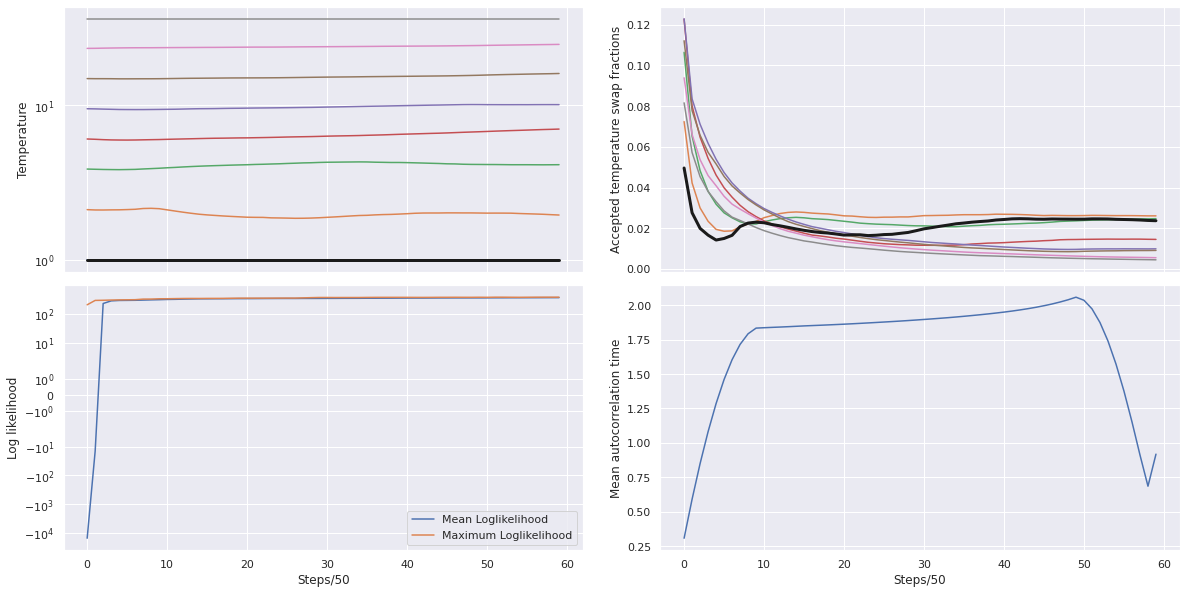

In [6]:
nauplot.plot_monitor()

It shows the movement of the adaptive temperatures, the swap between walkers of different temperatures, the Mean log likelihood and the Maximum log likelihood, and the mean autocorrelation time.

**Histograms**

Take a look into the posterior distributions, and set as titles the median and errors within $1-\sigma$

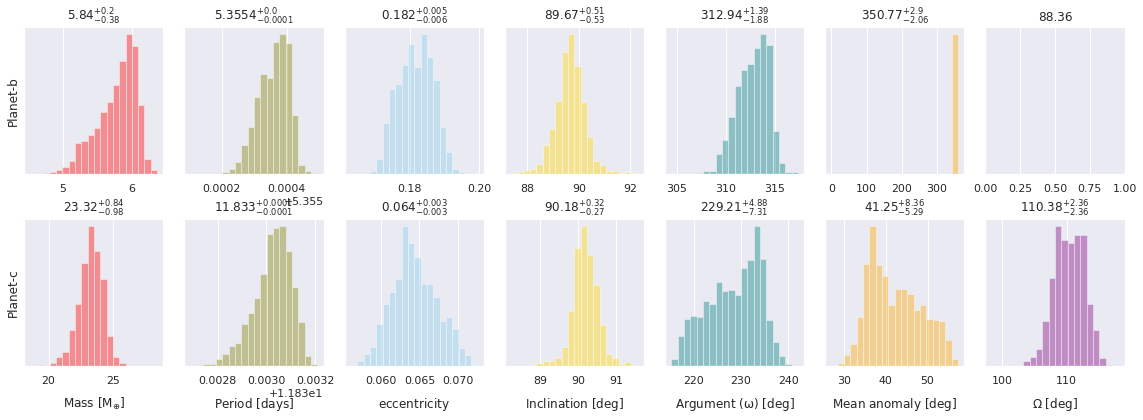

In [7]:
nauplot.plot_hist(titles=True)

**Chains**

If you are interested in visualizing the chains movement, use the  'plot_chains' method:

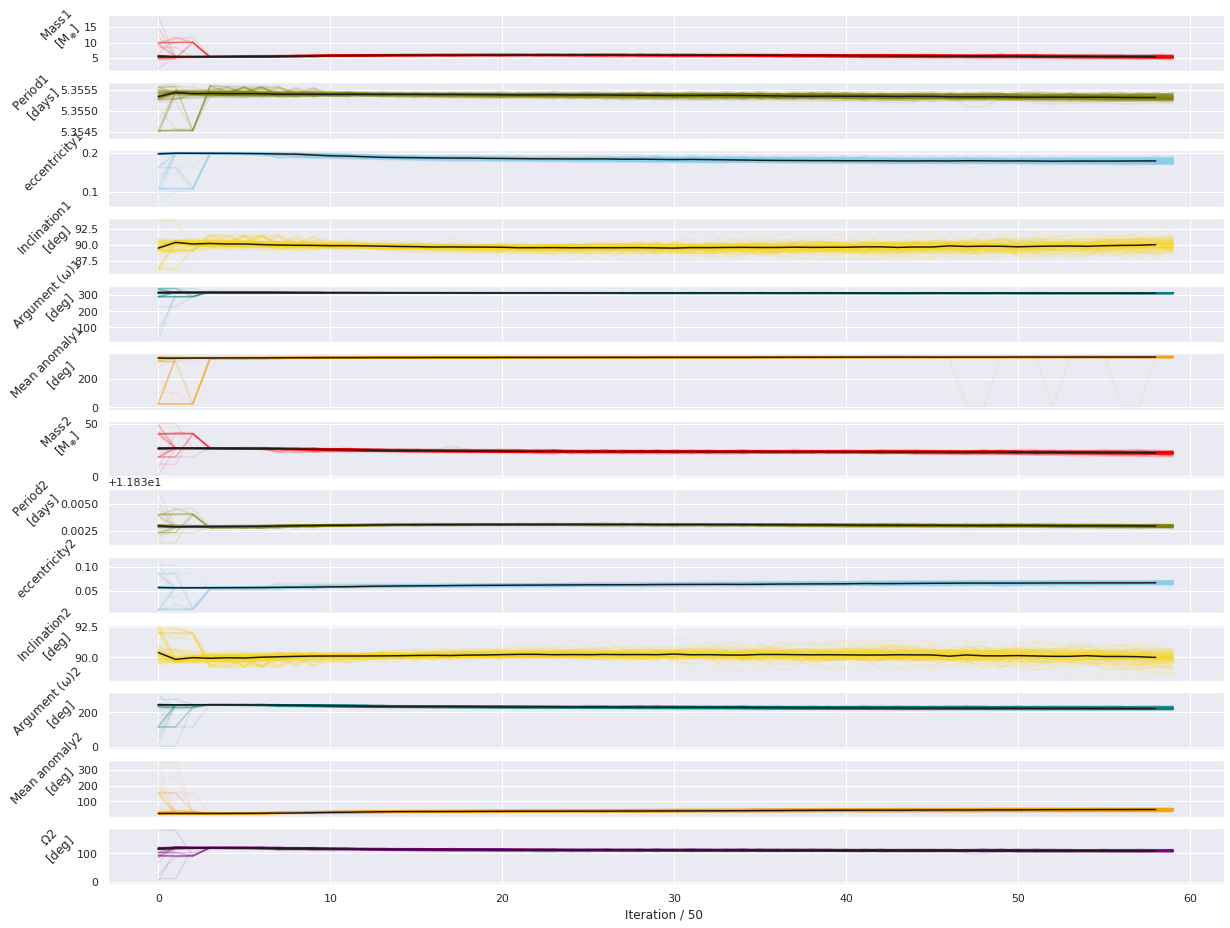

In [8]:
nauplot.plot_chains(plot_means=True)  # Plot the mean movement of the chains as black lines

**Corner plot**

And now a corner plot to visualize possible correlations between variables

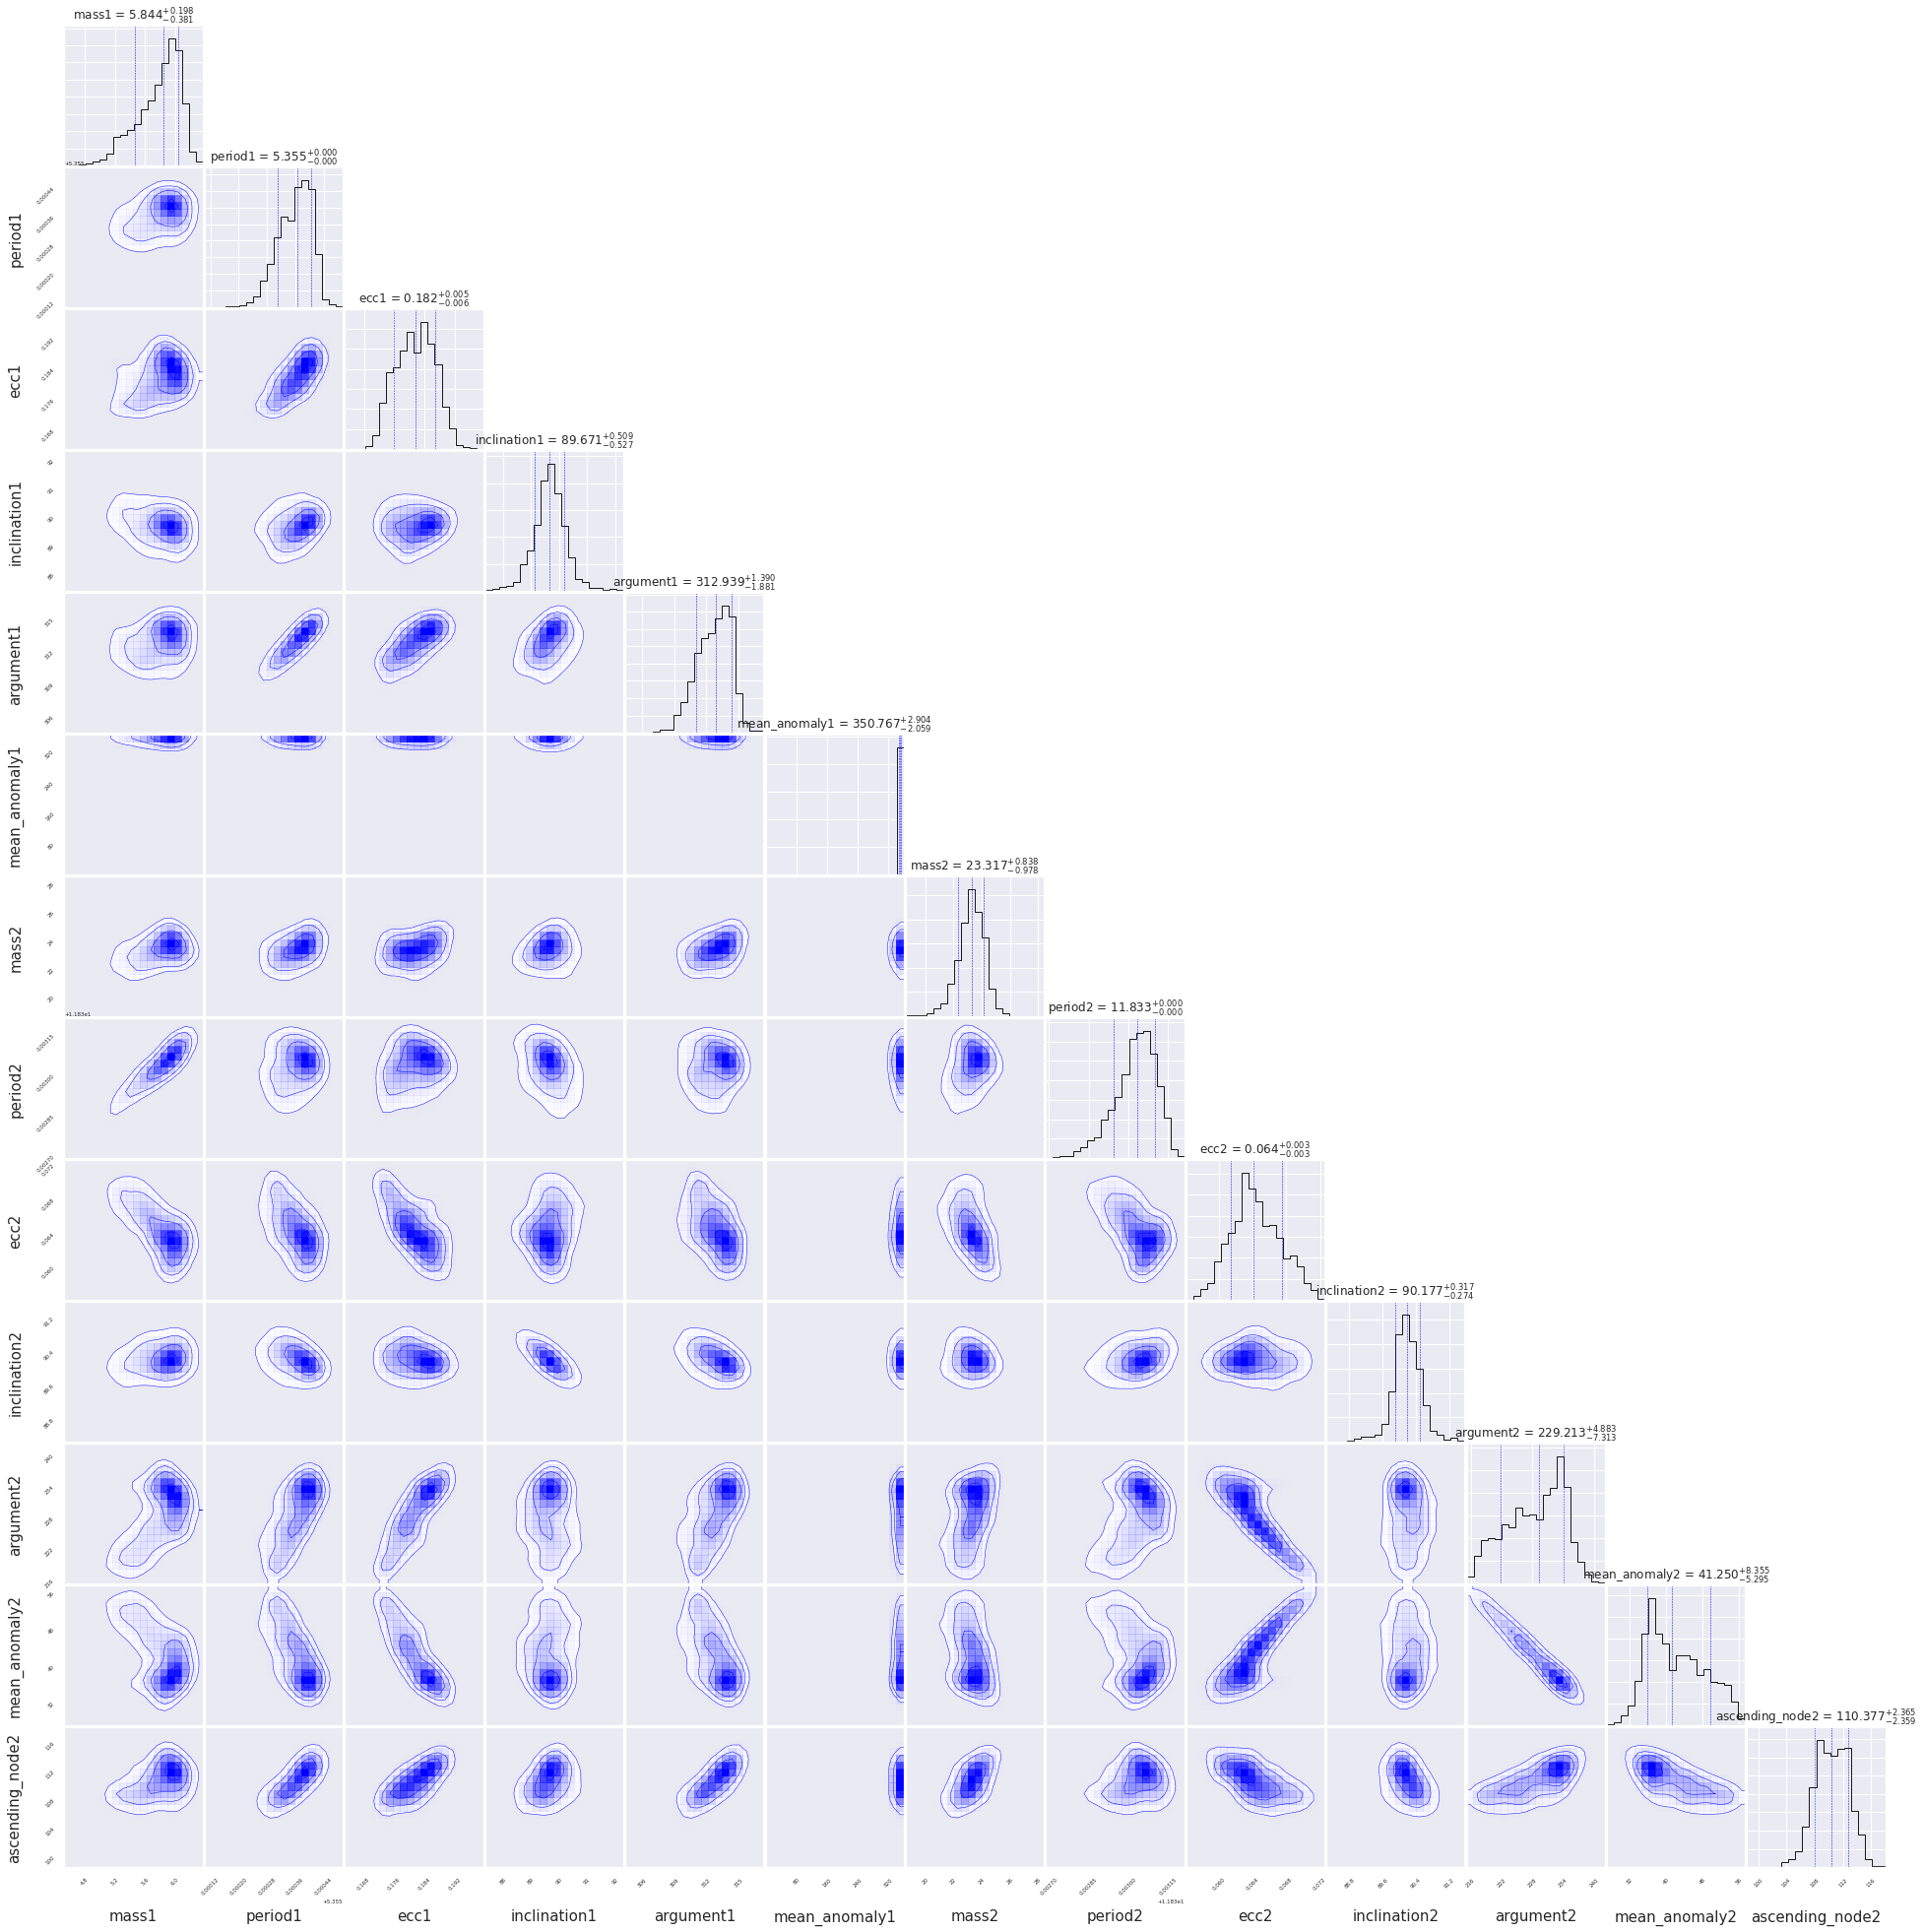

In [9]:
nauplot.plot_corner(color='blue', titles=True)

**TTVs**

In order to visualize the TTVs that the posteriors represent, use the function 'plot_TTVs'. It takes solutions from the MCMC chains to calculate the mid-transit times and the resulting TTVs. Two modes are available: mode 'random' take random samples from the chains; 'best' take the best solutions from the chains until complete -nsols-.

E3
random


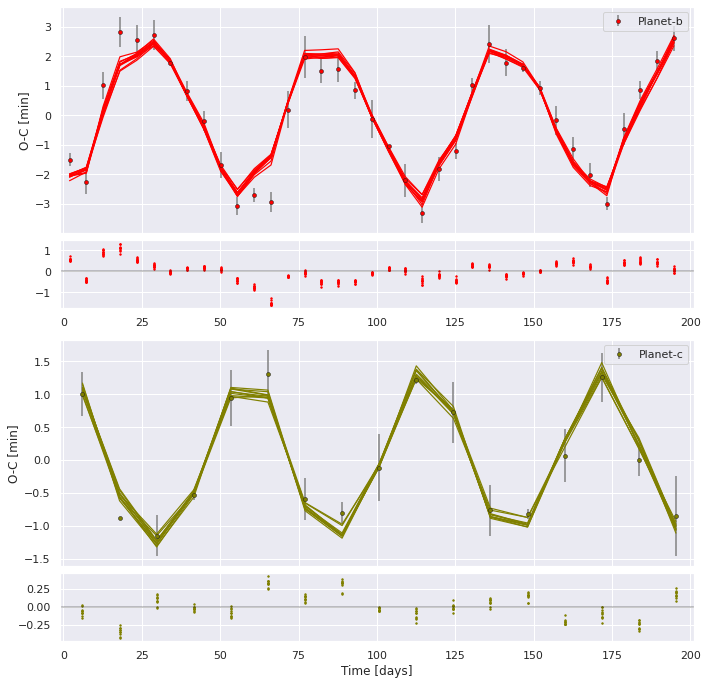

In [11]:
nauplot.plot_TTVs(mode='random',  # Take random samples from the posteriors.
                  nsols=10)       # Number of solutions to draw
plt.savefig('TTVs_mcmc.png')

That's a much better fitting than the done before with the optimizers in the previous tutorial. Compare yourself both images!

**At this point, we have seen how the MCMC module works. We also see the fast way of getting the results and how visualize them. If you are interested in going further in Nauyaca, the next tutorial will show all that extra features in the modules. See you there!**

_______________